In this project, I am trying to learn about RNN and be able to make forecast predictions. I will work with a sine wave and build out a RNN model using a simple RNN first and then with LSTM.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
x = np.linspace(0, 50, 501)
y = np.sin(x)

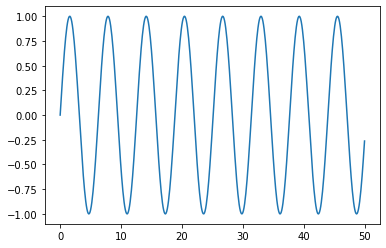

In [3]:
plt.plot(x, y)

In [4]:
df = pd.DataFrame(data=y, index=x, columns=['Sine'])

In [5]:
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [6]:
len(df)

501

we have 1001 rows in our df, let's do a 90% training set and a 10% test set

In [7]:
test_percent = 0.1

In [8]:
test_point = np.round(test_percent * len(df))

In [9]:
test_point

50.0

In [10]:
test_index = int(len(df) - test_point)

In [11]:
test_index

451

In [12]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

Now let's scale the data

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)

In [17]:
scaled_test = scaler.transform(test)

Now we can begin building our model. We will first use a simple RNN model for training

In [23]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Recall from our plot and from physics, the wavelength of a sine wave is 2 * pi. If we pick a length equivalency of roughly 6 units, we will be able to encapsulate almost an entire repeating sequence

(0.0, 10.0)

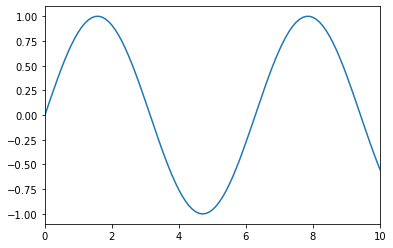

In [24]:
plt.plot(x, y)
plt.xlim(0,10)

Creating the model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [28]:
# we have to pick a length that is less than the length of our scaled_test
length = 49
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

In [29]:
# we have only 1 feature in our dataset
n_features = 1

In [30]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [31]:
model.fit(generator, epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop]
                   )

Epoch 1/20
402/402 [==============================] - 6s 12ms/step - loss: 0.0030 - val_loss: 1.0031e-06
Epoch 2/20
402/402 [==============================] - 5s 11ms/step - loss: 1.4727e-04 - val_loss: 2.0555e-04
Epoch 3/20
402/402 [==============================] - 5s 11ms/step - loss: 1.1605e-04 - val_loss: 1.5129e-04


In [32]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

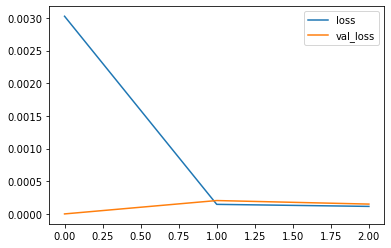

In [33]:
losses.plot()

<AxesSubplot:>

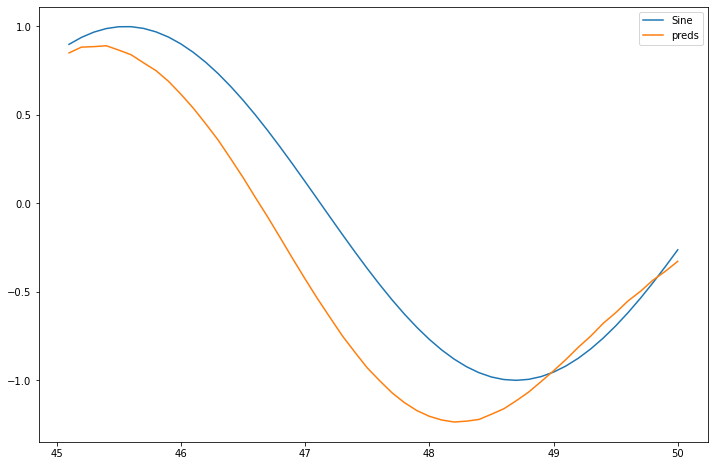

In [34]:
test_pred = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0] #getting the number instead of the array
    test_pred.append(current_pred)
    #update batch and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

test_pred = scaler.inverse_transform(test_pred)

df_plot = test.copy()
df_plot['preds'] = test_pred
df_plot.plot(figsize=(12,8))

Let's try a LSTM layer

In [35]:
model = Sequential()

model.add(LSTM(50,input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [36]:
model.fit(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
402/402 [==============================] - 14s 31ms/step - loss: 0.0082 - val_loss: 8.0050e-06
Epoch 2/20
402/402 [==============================] - 11s 28ms/step - loss: 2.2951e-04 - val_loss: 2.3484e-06
Epoch 3/20
402/402 [==============================] - 11s 28ms/step - loss: 2.6175e-04 - val_loss: 2.0933e-04
Epoch 4/20
402/402 [==============================] - 11s 27ms/step - loss: 1.1098e-04 - val_loss: 2.9159e-04


<AxesSubplot:>

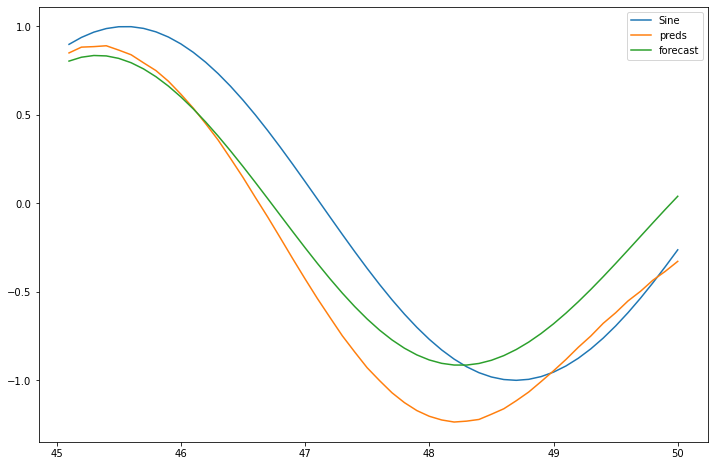

In [41]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0] #getting the number instead of the array
    forecast.append(current_pred)
    #update batch and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

forecast = scaler.inverse_transform(forecast)

# df_plot = test.copy()
df_plot['forecast'] = forecast
df_plot.plot(figsize=(12,8))

It looks like in general, the LSTM gave a better overall performance compared to a simple RNN